# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

In [3]:
run_name = "all"

In [4]:
target_dir = f"./logs/{run_name}/"
checkpoint_fn = None

max_iteration_num = 0
for fn in os.listdir(target_dir):
    if fn.endswith(".pt"):
        base_fn = os.path.basename(fn)
        iteration_num = int(base_fn.split("_")[1].split(".")[0])
        if iteration_num > max_iteration_num:
            max_iteration_num = iteration_num
            checkpoint_fn = os.path.join(target_dir, fn)

print(f"Using checkpoint: {checkpoint_fn}")

Using checkpoint: ./logs/all/grad_160.pt


In [5]:
# 247 for Libri-TTS model and 1 for single speaker (LJSpeech)
# N_SPKS = 247
N_SPKS = 1

In [6]:
sampling_rate = 22050

if run_name == "khkim2":
    params.n_enc_channels = 192
    params.filter_channels = 768
    params.filter_channels_dp = 256
    params.n_heads = 2
    params.use_pre_norm = False
elif run_name == "khkim_corrected":
    params.n_enc_channels = 256
    params.filter_channels = 1024
    params.filter_channels_dp = 256
    params.n_heads = 8
    params.use_pre_norm = True
elif run_name in ["khkim_large_weighted", "khkim_large_scaled", "large_scaled", "all"]:
    params.n_enc_channels = 256
    params.filter_channels = 1024
    params.filter_channels_dp = 256
    params.n_heads = 8
    params.use_pre_norm = True
else:
    raise ValueError("Unknown run_name: {}".format(run_name))

In [7]:
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000, use_pre_norm=params.use_pre_norm)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(torch.load(checkpoint_fn, map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./resources/cmu_dictionary')

Number of parameters: 20190616


In [8]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


In [9]:
def separate_jamo(char):
    """
    한글 문자를 초성, 중성, 종성으로 분리하는 함수
    :param char: 분리할 한글 문자
    :return: 분리된 초성, 중성, 종성 (없을 경우 빈 문자열)
    """
    # 한글 범위 내의 문자인지 확인
    if ord('가') <= ord(char) <= ord('힣'):
        # 초성 리스트와 중성 리스트, 종성 리스트
        chosung_list = [
            'ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ',
            'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ'
        ]
        jungsung_list = [
            'ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ',
            'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ',
            'ㅣ'
        ]
        jongsung_list = [
            '', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ',
            'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ',
            'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ'
        ]

        # 초성 코드 범위, 중성 코드 범위, 종성 코드 범위 계산
        char_code = ord(char) - ord('가')
        chosung_index = char_code // 588
        jungsung_index = (char_code - (chosung_index * 588)) // 28
        jongsung_index = char_code % 28

        # 초성, 중성, 종성 코드값 계산
        chosung = chosung_list[chosung_index]
        jungsung = jungsung_list[jungsung_index]
        jongsung = jongsung_list[jongsung_index]

        return chosung, jungsung, jongsung
    else:
        return char


In [10]:
# text = "Here are the match lineups for the Colombia Haiti match."
text = "안녕하세요 김기현입니다. 오늘 이 시간에는 우리가 왜 파이토치를 가지고 처음 인공지능을 시작해야 하는지, 한번 이야기해 보도록 할게요. 저야 뭐 일단은 파이토치가 처음 나왔을 때부터 썼어요. 그래가지고 파이토치 예전에 맨 처음에는 어떤 Theano라고 하는 이천 한 십삼년? 이 때쯤 쓰던 건데. 띠아노라고 하는 어떤 라이브러리를 썼었고 그거는 되게 어려웠던 기억이 있습니다. 그거는 뭐 지금 같이 좀 더 어.. 좋게 잘 구성이 되어있지 않았기 때문에 되게 어려웠어요."
text = "2022년 9월, 의미있는 대법원 판결이 나옵니다. 주한미군 위안부 피해자들이 제기한 손해배상소송에서 법원은 국가의 책임을 인정하고 피해자 개개인에게 1천만원씩을 배상하라고 판결했습니다. 소송을 시작한지 8년여만의 결과였습니다. 한국인들은 일반적으로 위안부라고 말하면 일본군 조선인 위안부를 생각합니다. 그들 이외의 위안부가 존재했다는 사실조차 모르는 경우도 많습니다. 한국전쟁 때 한국인으로 이루어진 위안부가 있었다거나, 군사정권 당시 미군을 위한 위안부가 존재했다는 사실은 잘 조명되지 않습니다. 특히나 한국군 위안부에 대해선 학계의 연구만들이 파편적으로 존재할 뿐 조직적인 과거사 조사나 피해자 단체가 전무합니다. 국방부에서 편찬한, 한국전쟁 당시의 전사를 다룬 «후방전사»에서 위안부의 존재가 확인됨에서 국방부는 이에 대해 부정합니다. 이 문제에 대해 처음 연구를 시작한 김귀옥 교수에 따르면 한국전쟁 당시 위안부들은 이념갈등의 희생양으로서 본인 혹은 가족이 인민군에 부역했다는 의심을 받는 여성들이 많았다고 합니다. 그렇기에 전쟁이 끝나고서도 자신이 피해자라고 밝히고 정부에 맞서 법적투쟁을 하기를 두려워합니다."
text = "40년 동안 SVB는 테크 스타트업과 초기 투자자들에게 필요한 것을 제공했다. 테크 스타트업은 평범한 사업방식에 충실하지 않고 고성장, 고위험을 추구했다. 이 회사들은 급성장에 우선순위를 두고, 사업전략을 자주 바꾸며, 실패를 배울 수 있는 기회로 찬양했다. 때때로 그들은 창업자의 바보 같은 아이디어에서 거대 대기업이 되기까지 믿기 힘든 속도로 성장하고, 수익분기점에 도달하기 이전부터 수십억 달러의 가치로 평가받았다. 가장 결정적으로, 테크 스타트업은 그들에게 필요한 자금, 노동자, 특정 서비스 제공자들의 긴밀한 네트워크에 의존했다."
text = "이게 문제가 병원 가서 심전도 해도 문제가 안나오는 경우가 많아서요. 그래도 병원 가보시는 걸 추천 드립니다. 전문가가 아니니 뭐라고 단언 드릴 수는 없지만 전 비슷한 증상에 병원 여러군데 갔었는데 결국은 정신과가 답이었습니다."
# text = "하이퍼 클로바 엑스 경쟁력은 비영어권에 특화된 인공지능이라는 점이다. 성낙호 네이버 클라우드 하이퍼 스케일 인공지능 기술총괄은 “챗 지피티와 비교해 한국어를 6500배 더 학습해, 사용자가 바라는 인공지능 모습을 구현할 수 있다”며 “특정 언어와 문화를 가장 잘 이해한 초대규모 인공지능을 통해 언어적 장벽으로 발생한 데이터 신뢰성 문제를 극복할 수 있을 것”이라고 말했다."
# text = "하이퍼 클로바 엑스의 경쟁력은, 비 영어권에 특화된 인공지능이라는 점이에요. 성낙호 네이버 클라우드 하이퍼 스케일 인공지능 기술총괄이 말했어요. 챗 지피티와 비교해서 한국어를 육천 오백배 더 학습해서, 어떤 사용자가 바라는 인공지능 모습을 구현할 수 있다 라고. 특정 언어와 문화를 가장 잘 이해한 초 대규모 인공지능을 통해서, 어떤 언어적 장벽으로 발생한 데이터의 신뢰성 문제를 극복할 수도 있을 것이다 라고 말했다는 거죠."
# text = "이제 우리는 새로운 목표를 세우고자 합니다. 우리가 모방하고자 하는 가상의 함수는 확률 분포를 출력으로 뱉어내는 함수라고 생각해보도록 하겠습니다. 기존에는 신경망 함수가 단순히 특정 샘플 벡터를 출력한다고 생각했었지만, 이제는 신경망 함수는 확률 분포를 표현하기 위한 벡터를 출력한다고 볼 수 있을 것입니다. 그렇다면 우리는 신경망을 통해 예측하는 과정을 좀 더 확률 통계 및 수학적인 관점에서 설명 가능할 것입니다. 또한 단순히 딱 정해진 값을 예측하도록 신경망을 학습하는 것이 아닌, 불확실성까지 예측하도록 학습시킬 수 있게 될 것입니다."
text = "자, 이제 우리는 새로운 목표를? 세워볼 거에요. 우리가 모방하고자 하는 가상의? 함수는 확률 분포를? 출력으로 뱉어내는 함수? 라고 생각해보죠. 기존에는 신경망 함수가 단순히 특정 샘플 벡터를? 출력한다고 생각했었지만? 이제는 신경망 함수는 확률 분포를 표현하기 위한 벡터를 출력한다고 볼 수 있을 거에요. 그럼 우리는 어떤 신경망을 통해 예측하는 과정을 좀 더 확률 통계 및 수학적인 관점에서 설명 가능하겠죠? 또한 단순히 딱, 정해진 값을 예측하도록, 신경망을 학습하는 것이 아닌, 불확실성까지 예측하도록, 학습시킬 수 있게 될 거에요."
# text = "김지우 어린이의 꿈은 뮤지컬 배우가 되는 거죠. 왜냐하면 지난 달에 뮤지컬 공연을 할 때? 굉장히 재미있었기 때문이죠. 김지우 잼민이는 지금 아홉살 이기 때문에, 많은 것들을 아직 할 수 없지만? 어른이 되면 많은 것들을 혼자서? 스스로 할 수 있을 거에요."

text = "".join(["".join(separate_jamo(c)) for c in text])

In [11]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 1389]), tensor([1389], device='cuda:0'))

Grad-TTS RTF: 0.5548705665202457


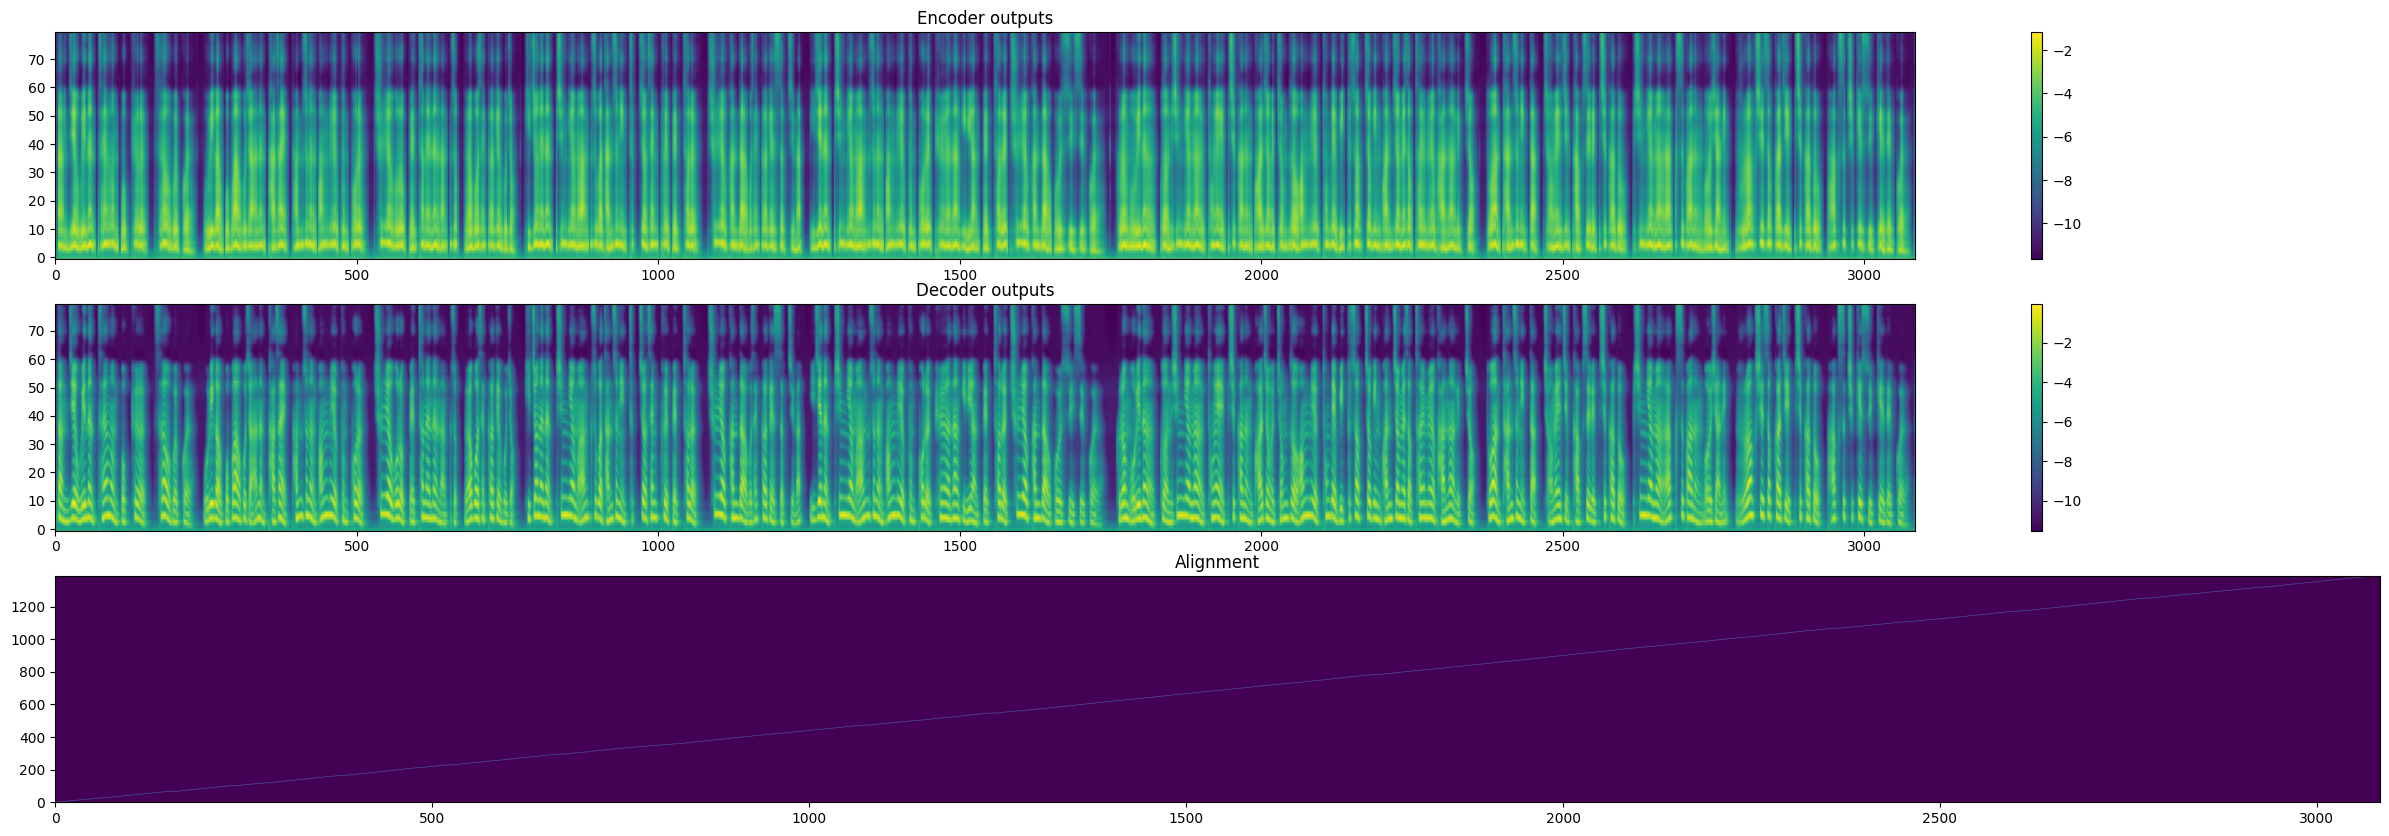

In [12]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=120, temperature=20.0,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=1.)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * sampling_rate / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(3, 1, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(3, 1, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower')

In [13]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=sampling_rate))

In [14]:
# save audio
audio = audio.numpy()
write(f'{run_name}.wav', sampling_rate, audio)